# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

In [2]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
trajectiories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','bactin_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

In [3]:
# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [4]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 4  # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 40     # PLEASE TEST MIN 5 MAX 200
simulation_time_in_sec = 30     # PLEASE TEST MIN 10 MAX 100
diffusion_coefficient = 0.55    # PLEASE TEST MIN 0.1 MAX 2

In [5]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 0 # 0 not using, 1 is using optimization
frame_selection_empty_video = 'shuffle' # Options are: 'constant' , 'shuffle' and 'loop'

In [6]:
particle_size = 5 # spot size for the simulation and tracking.
elongation_rate = 3
initiation_rate = 0.03

## Running the simulations

In [7]:
def fun_simulated_cells(current_dir,trajectiories_dir, video_dir,number_of_simulated_cells=3,number_spots_per_cell=80,simulation_time_in_sec =100,step_size_in_sec=1,particle_size=5, diffusion_coefficient =1,path_to_rSNAPsim= None, path_to_save_output='temp',intensity_calculation_method='gaussian_fit',frame_selection_empty_video=frame_selection_empty_video):
    spot_size = particle_size
    spot_sigma = 2
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.','_')
    
    directory_name = 'Simulation_V2__'+'ns_'+str(number_spots_per_cell) +'_diff_'+ diffusion_coefficient_string 
    path_to_save_output = 'temp'
    save_to_path =  current_dir.joinpath(path_to_save_output , directory_name )
    
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
        
    # Loading trajectories from file
    ssa_trajectories = np.load(str(trajectiories_dir))
    counter = 0
    ## Main loop that creates each cell and dataframe
    for cell_number in range (0, number_of_simulated_cells):
        ouput_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        #path_files = [ ouput_directory_name+'/'+f for f in list_files_names ] # creating the complete path for each file
        path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
        
        video_path = path_files[counter]        
        video = imread(video_path) 
        counter +=1
        if counter>=len(path_files):
            counter =0
        random_index_ch1 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
        random_index_ch2 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
        simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,0:simulation_time_in_sec:step_size_in_sec]
        simulated_trajectories_ch2 =  ssa_trajectories[random_index_ch2,0:simulation_time_in_sec:step_size_in_sec]
        # Simulations for intensity
#        ssa1 = rss.ssa_solver(n_traj = number_spots, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
#        simulated_trajectories = ssa1.intensity_vec
#        ssa2 = rss.ssa_solver(n_traj = number_spots, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
#        simulated_trajectories_blue = ssa2.intensity_vec
        # simulated trajectories for the green and blue channels
#        simulated_trajectories_ch2 = simulated_trajectories
#        simulated_trajectories_ch3 = simulated_trajectories_blue
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath('sim_cell_'+str(cell_number)))
        tensor_video , tensor_for_image_j , spot_positions_movement, tensor_mean_intensity_in_figure, tensor_std_intensity_in_figure, DataFrame_particles_intensities = rsp.SimulatedCell( base_video=video, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=None, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0,ignore_ch1=0, ignore_ch2=1,save_as_tif_uint8=0,save_as_tif =1,save_as_gif=0, save_dataframe=1, saved_file_name=saved_file_name,create_temp_folder = False, intensity_calculation_method=intensity_calculation_method,perform_video_augmentation=1,frame_selection_empty_video=frame_selection_empty_video).make_simulation()      
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path


In [8]:
# running the simulation
start = timer()
ouput_directory_name = fun_simulated_cells(current_dir,trajectiories_dir,video_dir,number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient,path_to_rSNAPsim= None,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video)
end = timer()
print('Time to generte simulated data:',round(end - start), ' sec')

Time to generte simulated data: 67  sec


In [9]:
#path = str(ouput_directory_name)

In [10]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(ouput_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file

# Reading the microscopy data
list_videos = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

In [11]:
# Reads the dataframes
list_files_dfnames = sorted([f for f in listdir(ouput_directory_name) if isfile(join(ouput_directory_name, f)) and ('.csv') in f], key=str.lower)  # reading all tif files in the folder
list_files_dfnames.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
#path_files_df = [ ouput_directory_name+'/'+f for f in list_files_dfnames ] # creating the complete path for each file
path_files_df = [ str(ouput_directory_name.joinpath(f).resolve()) for f in list_files_dfnames ] # creating the complete path for each file
list_df_real_positions = [pd.read_csv(f) for f in  path_files_df] # List with all the videos

## Display results as images

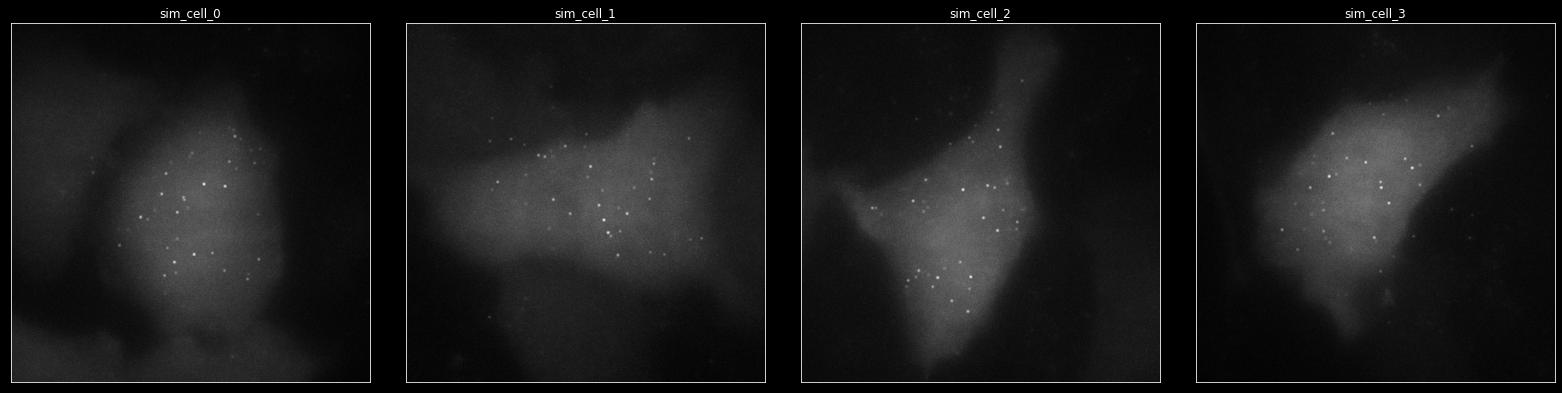

In [12]:
# Showing the simulated images
rsp.VisualizerImage(list_videos,list_files_names=list_files_names,selected_channel =0,selected_timepoint= 0,normalize=0,individual_figure_size=7).plot()

In [13]:
#rsp.VisualizerImage(list_videos,list_selected_particles_dataframe = list_df_real_positions,list_files_names=list_files_names,selected_channel =0,selected_timepoint= 0,normalize=0,individual_figure_size=7).plot()

  0%|          | 0/4 [00:00<?, ?it/s]

mask time: 12  sec
tracking time: 3  sec
intensity calculation time: 3  sec


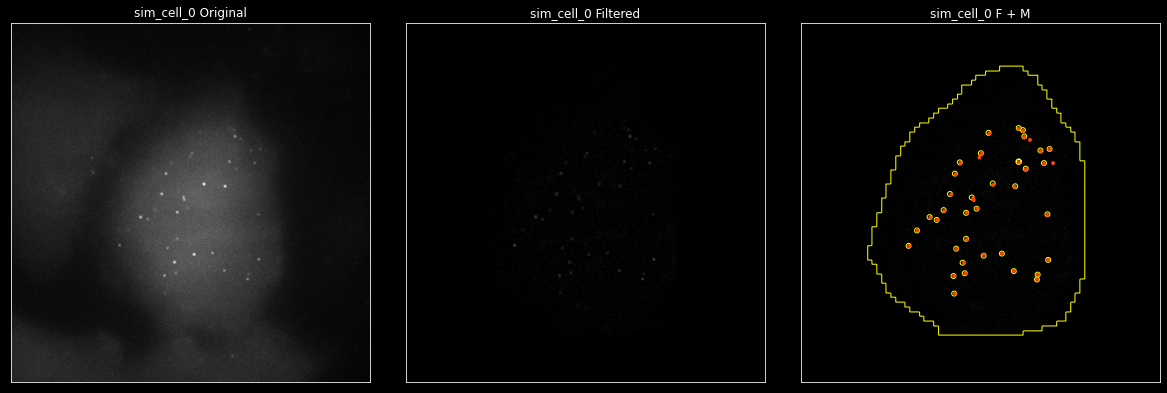

mask time: 12  sec
tracking time: 2  sec
intensity calculation time: 3  sec


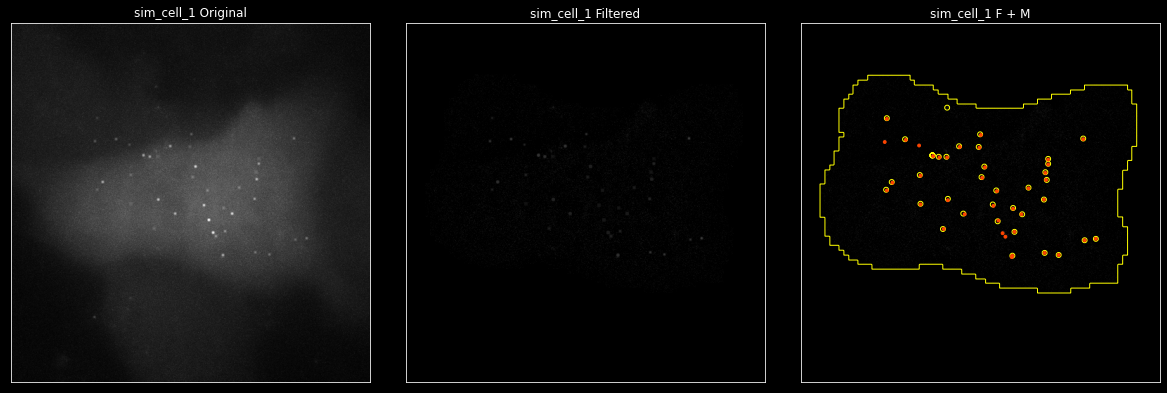

mask time: 11  sec
tracking time: 1  sec
intensity calculation time: 3  sec


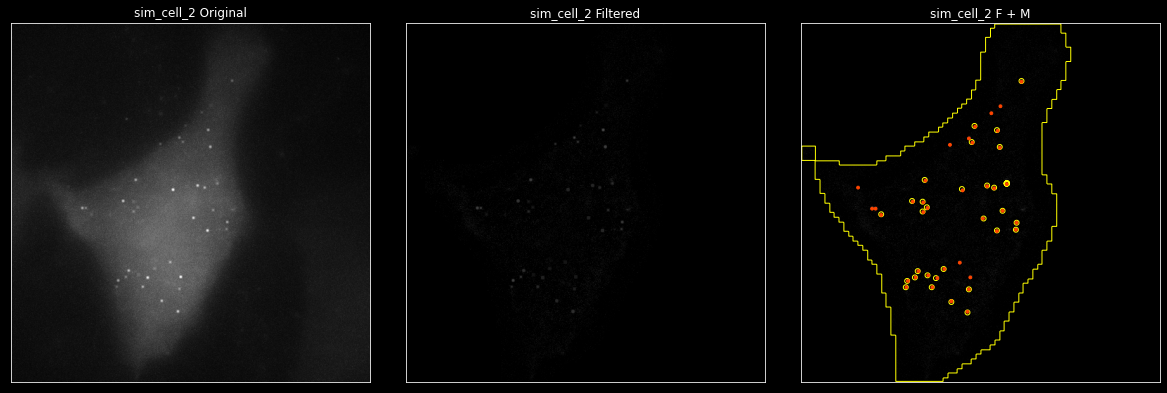

mask time: 12  sec
tracking time: 1  sec
intensity calculation time: 3  sec


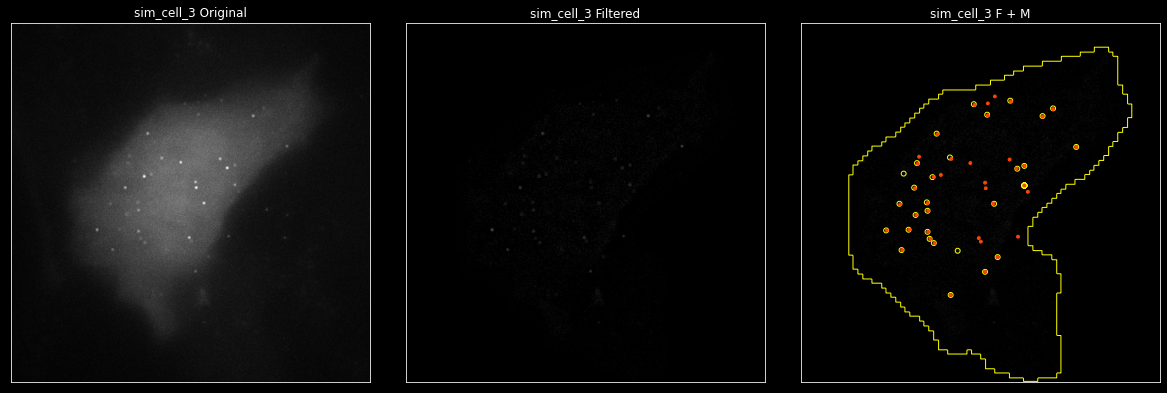

In [14]:
#intensity_selection_method =intensity_selection_method, mask_selection_method = mask_selection_method
list_DataFrame_particles_intensities= []
list_array_intensities = []
list_time_vector = []
for i in tqdm(range(0,nimg)): 
    DataFrame_particles_intensities, array_intensities, time_vector, mean_intensities,std_intensities, mean_intensities_normalized, std_intensities_normalized = rsp.PipelineTracking(list_videos[i],particle_size=particle_size,file_name=list_files_names[i],selected_channel=0,intensity_calculation_method =intensity_calculation_method, mask_selection_method = mask_selection_method,show_plot=1,use_optimization_for_tracking=use_optimization_for_tracking,real_positions_dataframe = list_df_real_positions[i],average_cell_diameter=200,print_process_times=1).run()    
    list_DataFrame_particles_intensities.append(DataFrame_particles_intensities)
    list_array_intensities.append(array_intensities)
    list_time_vector.append(time_vector)

# Comparing intensity distributions

## "Real" intensities from SSA

In [15]:
sel_timepoint = 0 #simulation_time_in_sec-1

In [16]:
def remove_extrema(vector,min_percentile = 0.1 ,max_percentile = 99.):
    '''This function is intended to remove extrema data given by the min and max percentiles specified by the user'''
    vector = vector [vector>0]
    max_val = np.percentile(vector, max_percentile)
    min_val =  np.percentile(vector, min_percentile)
    print(round(min_val,2),round(max_val,2))
    new_vector = vector [vector< max_val] # = np.percentile(vector,max_percentile)
    new_vector = new_vector [new_vector> min_val] # = np.percentile(vector, min_percentile)
    return new_vector

In [17]:
ssa_trajectories = np.load(str(trajectiories_dir))
ssa_trajectories_timePoint = ssa_trajectories[:,sel_timepoint].flatten()
#ssa_trajectories_timePoint= remove_extrema(ssa_trajectories_timePoint)
ssa_trajectories_timePoint_normalized = (ssa_trajectories_timePoint-np.amin(ssa_trajectories_timePoint))/ (np.amax(ssa_trajectories_timePoint)-np.amin(ssa_trajectories_timePoint))

## Recovered intensities from tracking

In [18]:
all_cells_green_int = np.array([])
for i in range(0,nimg): 
    all_cells_green_int = np.append(all_cells_green_int,list_array_intensities[i][:,sel_timepoint,1].flatten())   
all_cells_green_int = all_cells_green_int[all_cells_green_int>0]
all_cells_green_int= remove_extrema(all_cells_green_int)
all_cells_green_int_normalized = (all_cells_green_int-np.amin(all_cells_green_int))/ (np.amax(all_cells_green_int)-np.amin(all_cells_green_int))

57.98 1426.6


## Loading intensities from image. "Perfect tracking"

In [19]:
# Extracting the number of real simulations from folder name
path_str = str(ouput_directory_name)
ind_str_start = path_str.find('_ns_') +4
ind_str_end = path_str.find('_diff') 
max_nspots = int(path_str[ind_str_start:ind_str_end])
intensity_values_in_image = np.zeros((nimg,max_nspots)) # prealocating memory
for i in range(0,nimg):
    for j in range (0,max_nspots):
        #current_dir.parents[1].joinpath('DataBases','gene_files')
        #file_name = path+'/sim_cell_'+str(i)+'_df.csv'
        file_name = str(ouput_directory_name.joinpath('sim_cell_'+str(i)+'_df.csv'))
        #str(ouput_directory_name.joinpath(f).resolve())
        df_intensities_real = pd.read_csv(file_name)  
        intensity_values_in_image[i,j] = df_intensities_real[df_intensities_real['particle'] ==j].green_int_mean.values[sel_timepoint]         
intensity_values_in_image_flat = intensity_values_in_image.flatten()
intensity_values_in_image_flat =  intensity_values_in_image_flat[intensity_values_in_image_flat>0]
intensity_values_in_image_flat= remove_extrema(intensity_values_in_image_flat)
intensity_values_in_image_normalized = (intensity_values_in_image_flat-np.amin(intensity_values_in_image_flat))/ (np.amax(intensity_values_in_image_flat)-np.amin(intensity_values_in_image_flat)).flatten()

62.2 1402.86


# Intensity histograms with au

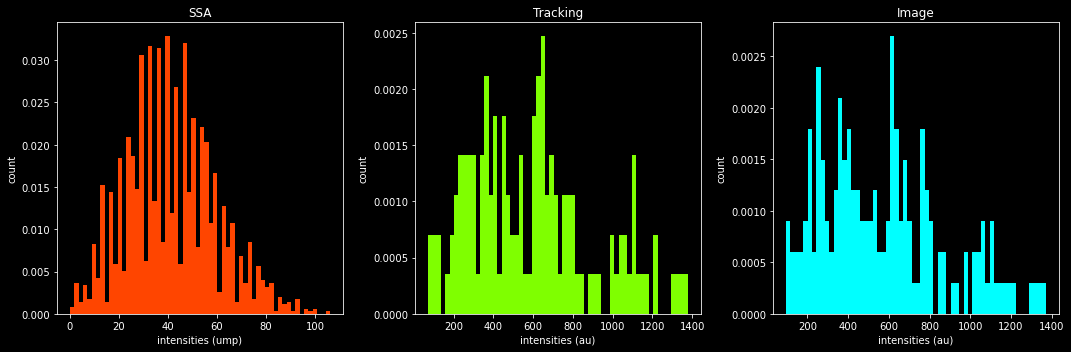

In [20]:
# plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].hist(ssa_trajectories_timePoint,bins=60,density=True, stacked=True, color='orangered' )     
axes[0].set(title='SSA')
axes[0].set(xlabel='intensities (ump)')
axes[0].set(ylabel='count')

axes[1].hist(all_cells_green_int,bins=60,density=True, stacked=True, color='chartreuse' )     
axes[1].set(title='Tracking')
axes[1].set(xlabel='intensities (au)')
axes[1].set(ylabel='count')

axes[2].hist(intensity_values_in_image_flat,bins=60,density=True, stacked=True, color='cyan' )     
axes[2].set(title='Image')
axes[2].set(xlabel='intensities (au)')
axes[2].set(ylabel='count')

plt.tight_layout();

## Normalizing intensities to 1.

$ X_{norm} = \frac{X -min(X)}{max(X) - min(X)} $

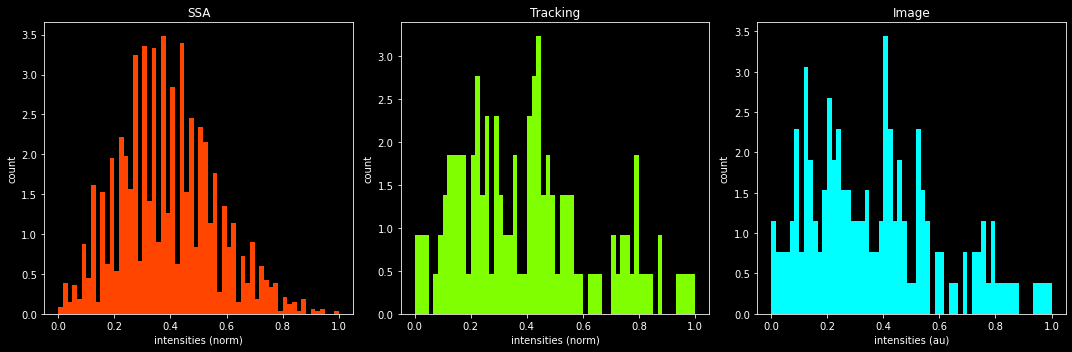

In [21]:
# plotting normalized intensities
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].hist(ssa_trajectories_timePoint_normalized,bins=60,density=True, stacked=True, color='orangered' )     
axes[0].set(title='SSA')
axes[0].set(xlabel='intensities (norm)')
axes[0].set(ylabel='count')

axes[1].hist(all_cells_green_int_normalized,bins=60,density=True, stacked=True, color='chartreuse' )     
axes[1].set(title='Tracking')
axes[1].set(xlabel='intensities (norm)')
axes[1].set(ylabel='count')

axes[2].hist(intensity_values_in_image_normalized,bins=60,density=True, stacked=True, color='cyan' )     
axes[2].set(title='Image')
axes[2].set(xlabel='intensities (au)')
axes[2].set(ylabel='count')

plt.tight_layout();

## Cummulative frequencies

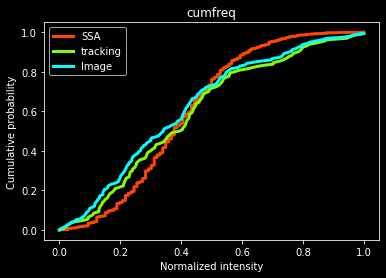

Number of spots for SSA: 2000
Number of spots recovered from tracking: 130
Number of spots recovered from image: 157


In [22]:
# Data
data1 = ssa_trajectories_timePoint_normalized
data_sorted_1 = np.sort(data1)
p_1 =np.linspace(0, 1, len(data1), endpoint=False)

data2 = all_cells_green_int_normalized
data_sorted_2 = np.sort(data2)
p_2 =np.linspace(0, 1, len(data2), endpoint=False)

data3 = intensity_values_in_image_normalized
data_sorted_3 = np.sort(data3)
p_3 =np.linspace(0, 1, len(data3), endpoint=False)

# Plotting
plt.plot(data_sorted_1, p_1, 'orangered',linewidth=3,label ='SSA')
plt.plot(data_sorted_2, p_2,'chartreuse',linewidth=3,label ='tracking')
plt.plot(data_sorted_3, p_3,'cyan',linewidth=3,label ='Image')

plt.legend()
plt.title('cumfreq');
plt.ylabel('Cumulative probability');
plt.xlabel('Normalized intensity');
plt.show()

# Print number of spots

print('Number of spots for SSA:',len(data1))
print('Number of spots recovered from tracking:',len(data2))
print('Number of spots recovered from image:',len(data3))

## Comparison using the KS-distance

In [23]:
# Calculating Kolmogorov distance

ks_distance = scipy.stats.kstest(data1,data2).statistic
print('The KS-distance between SSA and tracking is:' , round(ks_distance,2))

ks_distance = scipy.stats.kstest(data1,data3).statistic
print('The KS-distance between SSA and image is:' , round(ks_distance,2))

#ks_distance = scipy.stats.kstest(data3,data2).statistic
#print('The KS-distance between image and tracking is:' , round(ks_distance,2))

The KS-distance between SSA and tracking is: 0.13
The KS-distance between SSA and image is: 0.18
